<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек,-модулей" data-toc-modified-id="Импорт-библиотек,-модулей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек, модулей</a></span></li><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor-и-RandomForestRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-и-RandomForestRegressor-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Модель DecisionTreeRegressor и RandomForestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

**Цель исследования** - построить модель для предсказания количества заказов такси на следующий час.

Условия:

- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Задачи исследования:**

1. Загрузить данные и выполнить их ресемплирование по одному часу;
2. Проанализировать данные;
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных;
4. Проверить данные на тестовой выборке и сделать выводы.

**Ход исследования:**

В начале осмотрим данные: проверим датасет на наличие пропусков в данных и проверим соответствие значений в столбцах их типам.

Далее проведём исследовательский анализ данных. Построим график с распределением и числовым размахом для числовой переменной num_orders, проверим хронологию дат и доступный временной промежуток, проведём ресемплирование по одному часу. После разложим временной ряд на тренд, сезонную компоненту и остаток декомпозиции. В конце данного этапа определим с помощью статистического теста стационарность ряда.

На этапе подготовки данных добавим дополнительные признаки в датафрейм, подготовим выборки для обучения с учётом особенностей каждой выбранной модели. В случае с моделями LightGBM, DecisionTreeClassifier, RandomForestRegressor переведём часть признаков в тип category. Для линейной модели LinearRegression используем OHE кодирование.

Перейдём к обучению моделей. Первым делом обучим и оценим линейную модель. С помощью pipeline и RandomizedSearchCV для перебора гиперпараметров подберём лучшую модель из моделей RandomForestRegressor и DecisionTreeRegressor с учётом метрики качества RMSE - среднеквадратичной ошибки. Также используем RandomizedSearchCV для подбора параметров модели LGBMRegressor. В конце подсчитаем время обучения, предсказания и RMSE для каждой модели. RMSE на тестовой выборке должно быть не больше 48.

## Импорт библиотек, модулей

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
# импорт библиотек pandas, seaborn, matplotlib.pyplot

import numpy as np
from scipy import stats as st
from scipy.stats import shapiro
from scipy.stats import anderson

import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.pipeline import Pipeline
# загружаем класс pipeline

from sklearn.impute import SimpleImputer
# загружаем класс для работы с пропусками

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
# загружаем классы для подготовки данных

from sklearn.model_selection import RandomizedSearchCV
# импортируем класс RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# загружаем нужные модели

from sklearn.metrics import mean_squared_error
# загружаем функцию для работы с метриками

%config InlineBackend.figure_format='svg'
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Загрузка и обзор данных

In [4]:
try:
    taxi_df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    taxi_df = pd.read_csv('/Users/galina/Desktop/Яндекс.Практикум/Data Science/Спринт 18 Временные ряды/Спринт 18 проект/taxi.csv', parse_dates=[0], index_col=[0])
# чтение файлов с данными    

In [5]:
display(taxi_df.head(10))
display(taxi_df.info())
display(taxi_df.describe(include='all'))
display(taxi_df.columns)
# вывод характеристик датафрейма

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Index(['num_orders'], dtype='object')

Данные по количеству заказов представлены за каждые **10 мин. с 2018-03-01 по 2018-08-31**. Пропусков в данных не наблюдается. Типы данных указаны правильно. 

## Исследовательский анализ данных

Проверим, расположены ли данные в хронологическом порядке.

In [6]:
print(taxi_df.index.is_monotonic)
# использование атрибута is_monotonic

True


In [7]:
print(f'В нашем распоряжении данные с {taxi_df.index.min()} до {taxi_df.index.max()}')

В нашем распоряжении данные с 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Проведём ресемплирование по одному часу.

In [8]:
taxi_df_1H = taxi_df.resample('1H').sum()
# изменение интервала со значениями ряда

In [9]:
taxi_df_1H.head()
# вывод первых 5 строк

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
taxi_df_1H.describe()
# вывод описательной статистики

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [11]:
taxi_df_1H.info()
# вывод основной информации по датафрейму

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Среднее число поездок за *час* равно 84.4, медиана составляет **78** заказов. Число записей в датафрейме уменьшилось до 4416.

Посмотрим на график временного ряда.

In [12]:
taxi_df_1H['mean_day'] = taxi_df_1H['num_orders'].rolling(24).mean()
taxi_df_1H['mean_week'] = taxi_df_1H['num_orders'].rolling(24 * 7).mean()
# добавление столбцов со скользящими средними

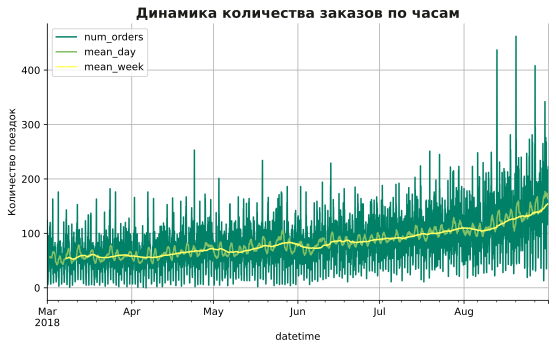

In [13]:
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(1, 1, 1)
# создание сетки под график
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# удаление линий осей
ax1.set_ylabel('Количество поездок')
# подпись оси y
taxi_df_1H.plot(ax=ax1, grid=True, cmap='summer')
# построение графика
ax1.set_title('Динамика количества заказов по часам',
              fontsize=14,
              fontweight='demi',
              color='#1B1B17');
# добавление заголовка

In [14]:
decomposed = seasonal_decompose(taxi_df_1H['num_orders'])
# разделение временного ряда на составляющие с помощью функции seasonal_decompose

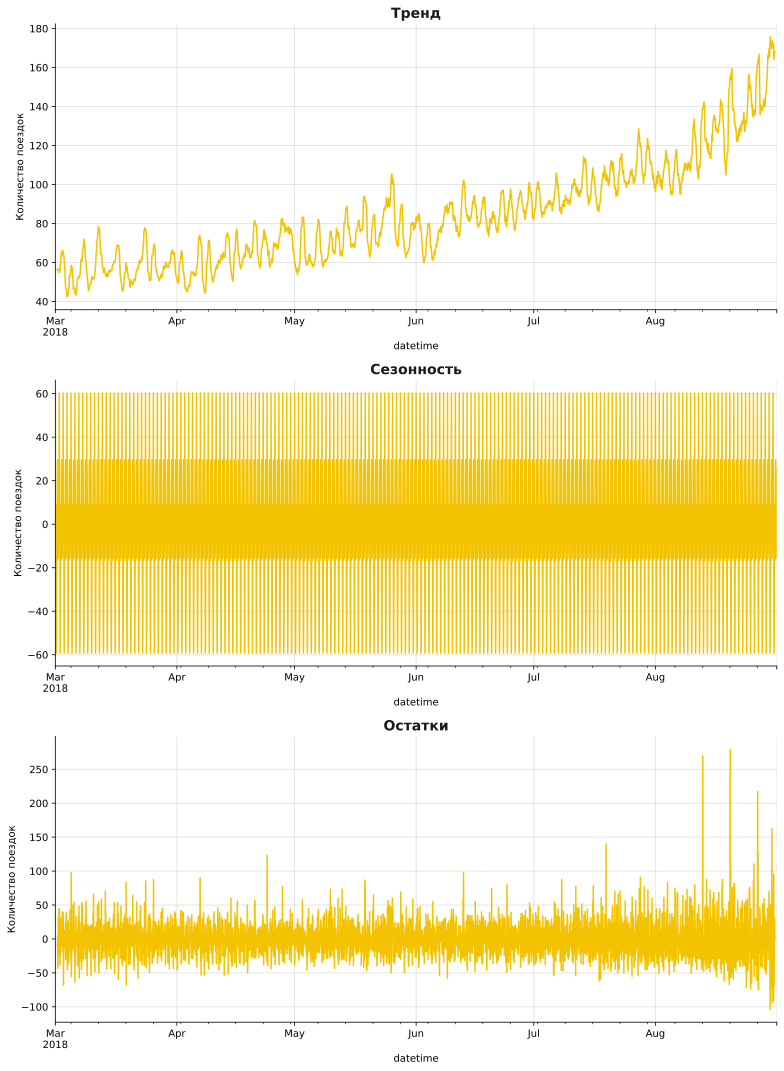

In [15]:
fig = plt.figure(figsize=(11, 15))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
# создание сетки из подграфиков
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
# удаление линий осей
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax2.grid(which='major', linewidth=1, color='gray',  alpha=0.2)
ax3.grid(which='major', linewidth=1, color='gray',  alpha=0.2)
# изменение параметров сетки
ax1.set_title('Тренд', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax2.set_title('Сезонность', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax3.set_title('Остатки', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
# назначение заголовков
decomposed.trend.plot(ax=ax1, grid=True, color='#F3C301')
decomposed.seasonal.plot(ax=ax2, grid=True, color='#F3C301')
decomposed.resid.plot(ax=ax3, grid=True, color='#F3C301')
# построение графиков
ax1.set_ylabel('Количество поездок')
ax2.set_ylabel('Количество поездок')
ax3.set_ylabel('Количество поездок')
# подпись осей

fig.tight_layout()
plt.show();
# вывод графиков

На графике с *трендом* наблюдается постепенный **рост числа заказов** с марта по август 2018 г., причём наибольший темп роста приходится на июль и август. Это может быть связано с большим количеством отпусков и выездов за город. Данную гипотезу можно проверить на даннных за несколько лет.

На графике сезонности сложно проследить какие-либо закономерности, рассмотрим сезонность на коротких промежутках времени. 

Посмотрим на тренд и сезонную составляющую на более коротких временных промежутках.

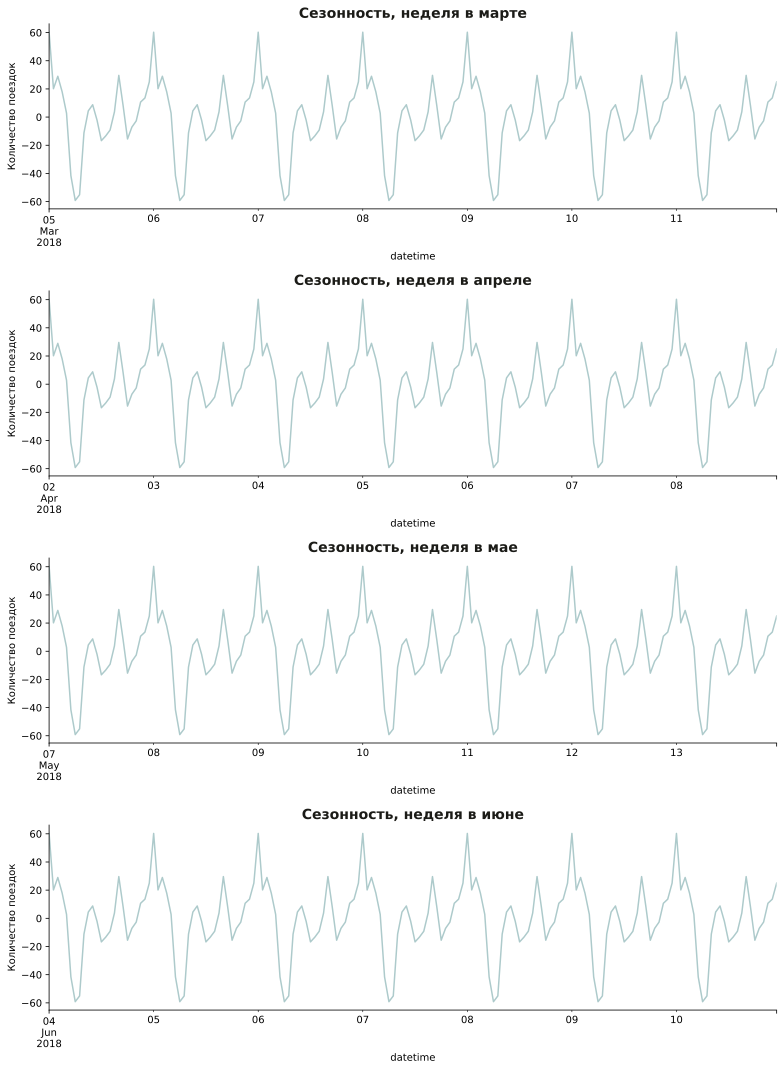

In [16]:
fig = plt.figure(figsize=(11, 15))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)
# создание сетки из подграфиков
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
# удаление линий осей
ax1.set_title('Сезонность, неделя в марте', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax2.set_title('Сезонность, неделя в апреле', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax3.set_title('Сезонность, неделя в мае', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax4.set_title('Сезонность, неделя в июне', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
# назначение заголовков
decomposed.seasonal['2018-03-05':'2018-03-11'].plot(ax=ax1, color='#ADCACB')
decomposed.seasonal['2018-04-02':'2018-04-08'].plot(ax=ax2, color='#ADCACB')
decomposed.seasonal['2018-05-07':'2018-05-13'].plot(ax=ax3, color='#ADCACB')
decomposed.seasonal['2018-06-04':'2018-06-10'].plot(ax=ax4, color='#ADCACB')
# создание графиков сезонности для разных недель
ax1.set_ylabel('Количество поездок')
ax2.set_ylabel('Количество поездок')
ax3.set_ylabel('Количество поездок')
ax4.set_ylabel('Количество поездок')
# подпись осей
fig.tight_layout()
plt.show();
# вывод графиков

Наибольший спад активности приходится на предрассветные часы, затем количество заказов начинает расти. После утренних часов пик спрос немного снижается. Ближе к вечеру заказы увеличиваются и достигают максимума к полуночи. В разные месяцы сезонность остается **неизменной** для каждого дня. 

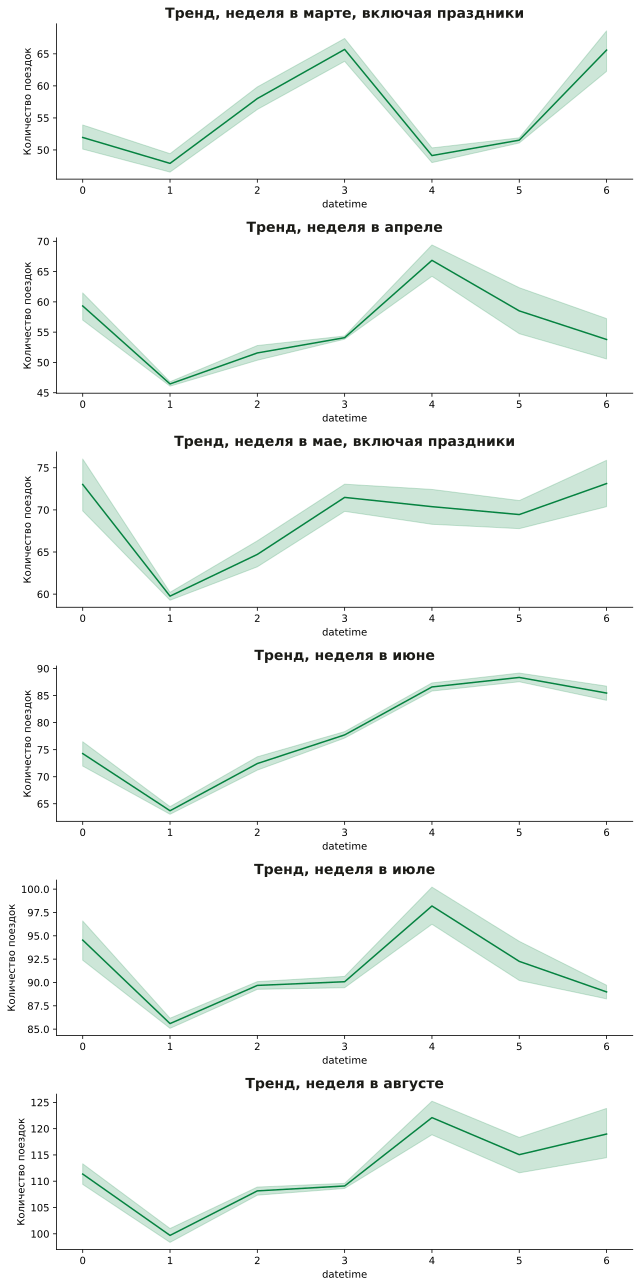

In [17]:
fig = plt.figure(figsize=(9, 18))
ax1 = fig.add_subplot(6, 1, 1)
ax2 = fig.add_subplot(6, 1, 2)
ax3 = fig.add_subplot(6, 1, 3)
ax4 = fig.add_subplot(6, 1, 4)
ax5 = fig.add_subplot(6, 1, 5)
ax6 = fig.add_subplot(6, 1, 6)
# создание сетки из подграфиков
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
# удаление линий осей
ax1.set_title('Тренд, неделя в марте, включая праздники', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax2.set_title('Тренд, неделя в апреле', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax3.set_title('Тренд, неделя в мае, включая праздники', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax4.set_title('Тренд, неделя в июне', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax5.set_title('Тренд, неделя в июле', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
ax6.set_title('Тренд, неделя в августе', 
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
# назначение заголовков
sns.lineplot(x=decomposed.trend['2018-03-05':'2018-03-11'].index.dayofweek,
              y=decomposed.trend['2018-03-05':'2018-03-11'].values,
              color='#058240',
              ax=ax1)
sns.lineplot(x=decomposed.trend['2018-04-02':'2018-04-08'].index.dayofweek,
              y=decomposed.trend['2018-04-02':'2018-04-08'].values,
              color='#058240',
              ax=ax2)
sns.lineplot(x=decomposed.trend['2018-05-07':'2018-05-13'].index.dayofweek,
              y=decomposed.trend['2018-05-07':'2018-05-13'].values,
              color='#058240',
              ax=ax3)
sns.lineplot(x=decomposed.trend['2018-06-04':'2018-06-10'].index.dayofweek,
              y=decomposed.trend['2018-06-04':'2018-06-10'].values,
              color='#058240',
              ax=ax4)
sns.lineplot(x=decomposed.trend['2018-07-02':'2018-07-08'].index.dayofweek,
              y=decomposed.trend['2018-07-02':'2018-07-08'].values,
              color='#058240',
              ax=ax5)
sns.lineplot(x=decomposed.trend['2018-08-06':'2018-08-12'].index.dayofweek,
              y=decomposed.trend['2018-08-06':'2018-08-12'].values,
              color='#058240',
              ax=ax6)
# создание графиков с трендом для разных недель
ax1.set_ylabel('Количество поездок')
ax2.set_ylabel('Количество поездок')
ax3.set_ylabel('Количество поездок')
ax4.set_ylabel('Количество поездок')
ax5.set_ylabel('Количество поездок')
ax6.set_ylabel('Количество поездок')
# подпись осей
fig.tight_layout()
plt.show();
# вывод графиков

Можно проследить тренд на *рост* числа поездок в **пятницу**, не включая недели с праздниками. *Минимальное* число заказов фиксируется во **вторник**. В марте с началом праздничных выходных спрос возрастает, затем падает и снова увеличивается к завершению праздничных выходных.

Определим, является ли наш ряд стационарным.

In [18]:
taxi_df_1H['std_week'] = taxi_df_1H['num_orders'].rolling(24 * 7).std()
# добавление столбца со стандартным отклонением

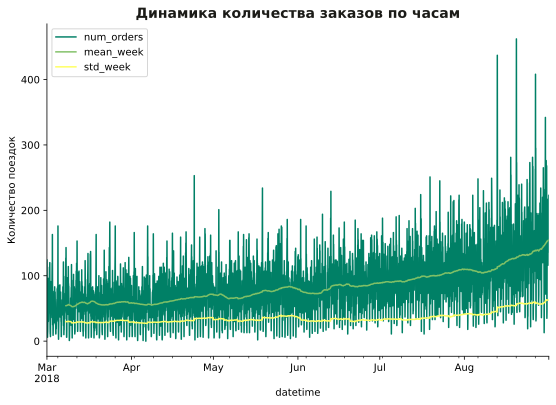

In [19]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(1, 1, 1)
# создание сетки из подграфиков
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# удаление линий осей
ax1.set_ylabel('Количество поездок')
# подпись оси y
ax1.set_title('Динамика количества заказов по часам',
              fontsize=14,
              fontweight='demi',
              color='#1B1B17')
# добавление заголовка
taxi_df_1H[['num_orders', 'mean_week', 'std_week']].plot(ax=ax1, cmap='summer');
# построение графика

Для проверки стационарности будем использовать статистический *тест Дики-Фуллера*.

In [20]:
stat_result = adfuller(taxi_df_1H['num_orders'])
# сохранение результатов статистического теста
print('ADF Statistic: %f' % stat_result[0])
print('p-value: %f' % stat_result[1])
print('Critical Values:')
for key, value in stat_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [21]:
print('Для 5% уровня значимости:')
print('')
if stat_result[1] < 0.05:
    print('Можем отклонить нулевую гипотезу о нестационарности ряда.')
else:
    print('Не можем отвергнуть нулевую гипотезу, ряд является нестационарным.')

Для 5% уровня значимости:

Можем отклонить нулевую гипотезу о нестационарности ряда.


In [22]:
print('Для 1% уровня значимости:')
print('')
if stat_result[1] < 0.01:
    print('Можем отклонить нулевую гипотезу о нестационарности ряда.')
else:
    print('Не можем отвергнуть нулевую гипотезу, ряд является нестационарным.')

Для 1% уровня значимости:

Не можем отвергнуть нулевую гипотезу, ряд является нестационарным.


Для *5% уровня значимости* можно назвать ряд стационарным, но при тестировании для *1% уровня значимости* мы уже не можем отклонить нулевую гипотезу о нестационарности ряда. Так как значение p-value пограничное, есть вероятность ложного срабатывания теста. В данном случае наш ряд является **нестационарным**.

## Создание признаков

In [23]:
taxi_df_1H.head()
# вывод первых 5 строк

,num_orders,mean_day,mean_week,std_week
datetime,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN


In [24]:
taxi_df_1H = taxi_df_1H.drop(['mean_week', 'std_week', 'mean_day'], axis=1)
# удаление лишних столбцов перед обучением

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    return data
# создание функции для добавления новых признаков  

In [26]:
make_features(taxi_df_1H, 24 * 7, 24 * 7).head()
# применение функции make_features параметрами max_lag - 168 и rolling_mean_size - 168

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


## Подготовка данных

Подготовим данные для моделей, которые мы будем обучать с перебором параметров в pipeline - **DecisionTreeRegressor** и **RandomForestRegressor**, а также для модели **LGBMRegressor**.

In [27]:
cat_columns = ['hour', 'dayofweek']
num_columns = list(taxi_df_1H.select_dtypes(include=[float]).columns)
# списки с категориальными и числовыми переменными

In [28]:
X = taxi_df_1H.drop('num_orders', axis=1)
y = taxi_df_1H['num_orders']

In [29]:
for column in cat_columns:
    if X.dtypes[column] == "int":
        X[column] = X[column].astype('category')
# перевод признаков в тип category
X.dtypes

hour            category
dayofweek       category
lag_1            float64
lag_2            float64
lag_3            float64
                  ...   
lag_165          float64
lag_166          float64
lag_167          float64
lag_168          float64
rolling_mean     float64
Length: 171, dtype: object

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,                                                                       
    y,                                                                      
    test_size=TEST_SIZE,                                                                       
    shuffle=False,                                                                       
    random_state=RANDOM_STATE)
# разделение выборки на тренировочную и тестовую для LGBMRegressor, DecisionTreeRegressor, RandomForestRegressor, LinearRegression 

In [31]:
print(f'''Количество строк в тренировочной выборке: {X_train.shape[0]}
Количество признаков в тренировочной выборке: {X_train.shape[1]}''')

Количество строк в тренировочной выборке: 3823
Количество признаков в тренировочной выборке: 171


In [32]:
print(f'''Количество строк в тестовой выборке: {X_test.shape[0]}
Количество признаков в тестовой выборке: {X_test.shape[1]}''')

Количество строк в тестовой выборке: 425
Количество признаков в тестовой выборке: 171


In [33]:
X_train.head()
# вывод первых 5 строк тренировочной выборки

,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


Для линейной регресии **LinearRegression** закодируем категориальные переменные c помощью *OneHotEncoder* и масштабируем числовые признаки в pipeline на следующем этапе.

## Обучение моделей

###  Линейная модель

In [34]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder())
    ]
    )
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
# создаём общий пайплайн для подготовки данных - кодирования и масштабирования

In [35]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
# создаём итоговый пайплайн: подготовка данных и модель

param_grid = [    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
    # словарь для модели LinearRegression()
]

In [36]:
splits = TimeSeriesSplit(n_splits=3)
# TimeSeriesSplit
randomized_search_lin = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=splits,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# запуск поиска гиперпараметров с помощью GridSearchCV

randomized_search_lin.fit(X_train, y_train)
# обучение модели

print('Лучшая модель и её параметры:\n\n', randomized_search_lin.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['hour', 'dayofweek']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12'

In [37]:
print('Метрика RMSE лучшей модели на кросс валидационной выборке:', round(randomized_search_lin.best_score_ * (-1), 3))

Метрика RMSE лучшей модели на кросс валидационной выборке: 23.554


### Модель DecisionTreeRegressor и RandomForestRegressor

In [38]:
pipe_final = Pipeline([
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])
# создаём итоговый пайплайн: подготовка данных и модель

In [39]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 10),
        'models__min_samples_leaf': range(2, 7) 
    },
    # словарь для модели DecisionTreeRegressor()
    
    {
        'models': [RandomForestRegressor()],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 5),
        'models__max_features': range(2, 10)
    }
    # словарь для модели RandomForestRegressor()
]

In [40]:
splits = TimeSeriesSplit(n_splits=3)
# TimeSeriesSplit
randomized_search_rfr = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=splits,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# запуск поиска гиперпараметров с помощью RandomizedSearchCV

randomized_search_rfr.fit(X_train, y_train)
# обучение модели

print('Лучшая модель и её параметры:\n\n', randomized_search_rfr.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 RandomForestRegressor(max_depth=18, max_features=9,
                                       min_samples_split=3))])


In [41]:
print('Метрика RMSE лучшей модели на кросс валидационной выборке:', round(randomized_search_rfr.best_score_ * (-1), 3))

Метрика RMSE лучшей модели на кросс валидационной выборке: 25.556


### LightGBM

In [42]:
params = {'num_leaves': [n for n in range(2, 25)], 
          'learning_rate': [0.01, 0.1], 
          'n_estimators': [25, 50],
          'max_depth': [n for n in range(5, 25)],
          'verbose': [-1]
         }
# объявление словаря с значениями параметров для модели

In [43]:
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE)
# инициализируем модель
splits = TimeSeriesSplit(n_splits=3)
# TimeSeriesSplit
lgb_randomized_search = RandomizedSearchCV(estimator=model_lgb,
                            param_distributions=params,
                            cv=splits,               
                            scoring='neg_root_mean_squared_error',
                            verbose=-1)
# запуск поиска гиперпараметров с помощью RandomizedSearchCV
lgb_randomized_search.fit(X_train, y_train)
# обучение модели

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15, 16, 17, 18,
                                                      19, 20, 21, 22, 23, 24],
                                        'n_estimators': [25, 50],
                                        'num_leaves': [2, 3, 4, 5, 6, 7, 8, 9,
                                                       10, 11, 12, 13, 14, 15,
                                                       16, 17, 18, 19, 20, 21,
                                                       22, 23, 24],
                                        'verbose': [-1]},
                   scoring='neg_root_mean_squared_error', verbose=-1)

In [44]:
print(lgb_randomized_search.best_params_)
print('')
print(f'Метрика RMSE лучшей модели на кросс валидационной выборке: {round((lgb_randomized_search.best_score_ * (-1)), 3)}')

{'verbose': -1, 'num_leaves': 7, 'n_estimators': 50, 'max_depth': 24, 'learning_rate': 0.1}

Метрика RMSE лучшей модели на кросс валидационной выборке: 23.944


После обучения моделей лучший результат на кросс-валидационной выборке показала модель **LinearRegression** с показателем среднеквадратичной ошибки RMSE - *23.554*.

## Тестирование моделей

Оценим качество модели **LinearRegression** на тестовой выборке.

In [45]:
print(f'Значение метрики RMSE для тестовой выборки линейной модели: {round(mean_squared_error(y_test, randomized_search_lin.best_estimator_.predict(X_test))**0.5, 3)}')

Значение метрики RMSE для тестовой выборки линейной модели: 33.866


Модель с самой маленькой среднеквадратичной ошибкой RMSE на кросс-валидационной выборке - LinearRegression 23.554, на втором месте LGBMRegressor 23.944 и на последнем RandomForestRegressor 25.556. Показатель качества RMSE лучшей модели **LinearRegression** на *тестовой выборке* равен **33.866**, что соответствует условию RMSE <= 48.